<a href="https://www.kaggle.com/code/rohanrathod02/predicting-loan-payback-eda-adv-fe-ensemble?scriptVersionId=279306210" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv
/kaggle/input/loan-prediction-dataset-2025/loan_dataset_20000.csv


# Introduction  
This notebook provides a clear and simple workflow for the **“Predicting Loan Payback” — Kaggle Playground Series S5E11** competition.  
We will go through the full process: **loading the data, exploring it, preprocessing, training models, evaluating them, and creating a valid submission file**.

---

## What is Loan Payback Prediction?  
Loan payback prediction means identifying whether a borrower will **repay the loan** or **default**.  
This is a binary classification problem.

The result depends on factors such as:

- Borrower income, age, employment  
- Loan amount, interest rate  
- Credit history and past defaults  
- Other financial indicators  

---

## Competition Objective  
Your goal is to **predict the target column indicating loan payback** for each entry in the test set.

### ✔ Evaluation Metric  
The competition uses **AUC ROC**, which measures how well the model separates positive vs negative classes.

---

## About the Dataset  
- The dataset contains **synthetic loan records** created for practice.  
- It includes both **numerical** and **categorical** features.  
- The train, test, and sample submission files are located in your Drive:  


# 1. Setup & data loading

In [9]:


# ====================================================
# Setup & Imports
# ====================================================

import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


 
# Settings for cleaner output and consistent plotting
warnings.filterwarnings("ignore") # Suppress warnings for cleaner output
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8) # Default figure size for plots

# Reproducibility
SEED = 42
N_SPLITS = 7
TARGET = 'loan_paid_back'

In [10]:
import pandas as pd
import numpy as np

# --- 1. Load datasets ---
print("Loading datasets...")
train_path = '/kaggle/input/playground-series-s5e11/train.csv'
test_path = '/kaggle/input/playground-series-s5e11/test.csv'
orig_path = '/kaggle/input/loan-prediction-dataset-2025/loan_dataset_20000.csv'
sample_submission_path = '/kaggle/input/playground-series-s5e11/sample_submission.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_orig = pd.read_csv(orig_path)
df_sample_submission = pd.read_csv(sample_submission_path)
print("Datasets loaded successfully.")

# --- 2. Print the shape of each dataset ---
print("\n--- Dataset Shapes ---")
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_test: {df_test.shape}")
print(f"Shape of df_orig: {df_orig.shape}")
print(f"Shape of df_sample_submission: {df_sample_submission.shape}")

Loading datasets...
Datasets loaded successfully.

--- Dataset Shapes ---
Shape of df_train: (593994, 13)
Shape of df_test: (254569, 12)
Shape of df_orig: (20000, 22)
Shape of df_sample_submission: (254569, 2)


# 2. Exploratory data analysis

## 2.1 Data information

In [11]:
def data_info(df, df_name):
    """Comprehensive overview of a DataFrame with styled output."""

    print(f"\n{'='*80}")
    print(f"📊 Comprehensive Information for DataFrame: {df_name}")
    print(f"{'='*80}\n")

    # --- Shape ---
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

    # --- Head ---
    print(f"--- {df_name} Head ---\n")
    display(df.head().style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Column Summary ---
    print(f"\n--- {df_name} Column Summary ---\n")
    summary = pd.DataFrame({
        "DataType": df.dtypes,
        "Non-Null Count": df.notnull().sum(),
        "Unique Values": df.nunique(),
        "Missing Values": df.isnull().sum(),
        "Missing %": (df.isnull().sum() / len(df)) * 100
    })
    display(summary.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Describe (numeric only) ---
    if df.select_dtypes(include=np.number).shape[1] > 0:
        print(f"\n--- {df_name} Numeric Summary ---\n")
        display(df.describe().style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
            {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False))

    # --- Describe (categorical only) ---
    cat_cols = df.select_dtypes(exclude=np.number).columns
    if len(cat_cols) > 0:
        print(f"\n--- {df_name} Categorical Summary ---\n")
        cat_summary = df[cat_cols].describe().transpose()
        display(cat_summary.style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
            {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False))

    print(f"\n{'='*80}\n")

# Apply
data_info(df_train, "df_train")
data_info(df_test, "df_test")


📊 Comprehensive Information for DataFrame: df_train

Shape: 593994 rows × 13 columns

--- df_train Head ---



,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.990000,0.084000,736,2528.420000,13.670000,Female,Single,High School,Self-employed,Other,C3,1.000000
1,1,22108.020000,0.166000,636,4593.100000,12.920000,Male,Married,Master's,Employed,Debt consolidation,D3,0.000000
2,2,49566.200000,0.097000,694,17005.150000,9.760000,Male,Single,High School,Employed,Debt consolidation,C5,1.000000
3,3,46858.250000,0.065000,533,4682.480000,16.100000,Female,Single,High School,Employed,Debt consolidation,F1,1.000000
4,4,25496.700000,0.053000,665,12184.430000,10.210000,Male,Married,High School,Employed,Other,D1,1.000000



--- df_train Column Summary ---



,DataType,Non-Null Count,Unique Values,Missing Values,Missing %
id,int64,593994,593994,0,0.000000
annual_income,float64,593994,119728,0,0.000000
debt_to_income_ratio,float64,593994,526,0,0.000000
credit_score,int64,593994,399,0,0.000000
loan_amount,float64,593994,111570,0,0.000000
interest_rate,float64,593994,1454,0,0.000000
gender,object,593994,3,0,0.000000
marital_status,object,593994,4,0,0.000000
education_level,object,593994,5,0,0.000000
employment_status,object,593994,5,0,0.000000



--- df_train Numeric Summary ---



,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,296996.500000,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,171471.442235,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,0.000000,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,148498.250000,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,296996.500000,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,445494.750000,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,593993.000000,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000



--- df_train Categorical Summary ---



,count,unique,top,freq
gender,593994,3,Female,306175
marital_status,593994,4,Single,288843
education_level,593994,5,Bachelor's,279606
employment_status,593994,5,Employed,450645
loan_purpose,593994,8,Debt consolidation,324695
grade_subgrade,593994,30,C3,58695





📊 Comprehensive Information for DataFrame: df_test

Shape: 254569 rows × 12 columns

--- df_test Head ---



,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,28781.050000,0.049000,626,11461.420000,14.730000,Female,Single,High School,Employed,Other,D5
1,593995,46626.390000,0.093000,732,15492.250000,12.850000,Female,Married,Master's,Employed,Other,C1
2,593996,54954.890000,0.367000,611,3796.410000,13.290000,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,593997,25644.630000,0.110000,671,6574.300000,9.570000,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,593998,25169.640000,0.081000,688,17696.890000,12.800000,Female,Married,PhD,Employed,Business,C1



--- df_test Column Summary ---



,DataType,Non-Null Count,Unique Values,Missing Values,Missing %
id,int64,254569,254569,0,0.000000
annual_income,float64,254569,67287,0,0.000000
debt_to_income_ratio,float64,254569,506,0,0.000000
credit_score,int64,254569,389,0,0.000000
loan_amount,float64,254569,65199,0,0.000000
interest_rate,float64,254569,1385,0,0.000000
gender,object,254569,3,0,0.000000
marital_status,object,254569,4,0,0.000000
education_level,object,254569,5,0,0.000000
employment_status,object,254569,5,0,0.000000



--- df_test Numeric Summary ---



,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate
count,254569.000000,254569.000000,254569.000000,254569.000000,254569.000000,254569.000000
mean,721278.000000,48233.080193,0.120583,681.037691,15016.753484,12.352323
std,73487.884676,26719.658580,0.068582,55.624118,6922.165182,2.017602
min,593994.000000,6011.770000,0.011000,395.000000,500.050000,3.200000
25%,657636.000000,27950.300000,0.072000,646.000000,10248.580000,10.980000
50%,721278.000000,46528.980000,0.096000,683.000000,15000.220000,12.370000
75%,784920.000000,61149.440000,0.156000,719.000000,18831.460000,13.690000
max,848562.000000,380653.940000,0.627000,849.000000,48959.260000,21.290000



--- df_test Categorical Summary ---



,count,unique,top,freq
gender,254569,3,Female,131480
marital_status,254569,4,Single,123686
education_level,254569,5,Bachelor's,119924
employment_status,254569,5,Employed,193207
loan_purpose,254569,8,Debt consolidation,138963
grade_subgrade,254569,30,C3,25410


## 2.2 Numerical/Categorical Feature Identification

In [12]:
# Define excluded features: 'id' and the target variable 'loan_paid_back'
excluded_features = ['id', 'loan_paid_back']

print("\n--- Feature Classification Based on df_train ---")

# Separate numerical features from df_train, excluding the specified features
numerical_features = [
    col for col in df_train.select_dtypes(include=np.number).columns
    if col not in excluded_features
]

# Separate categorical features from df_train, excluding the specified features
categorical_features = [
    col for col in df_train.select_dtypes(exclude=np.number).columns
    if col not in excluded_features
]


print("Numerical Features:")
print(f"  Total Count: {len(numerical_features)}")
print(f"  List: {numerical_features}\n")

print("Categorical Features:")
print(f"  Total Count: {len(categorical_features)}")
print(f"  List: {categorical_features}\n")

print("Excluded Features (ID and Target Variable):")
print(f"  List: {excluded_features}\n")


--- Feature Classification Based on df_train ---
Numerical Features:
  Total Count: 5
  List: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']

Categorical Features:
  Total Count: 6
  List: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']

Excluded Features (ID and Target Variable):
  List: ['id', 'loan_paid_back']



## 2.3 Correlation Heatmap

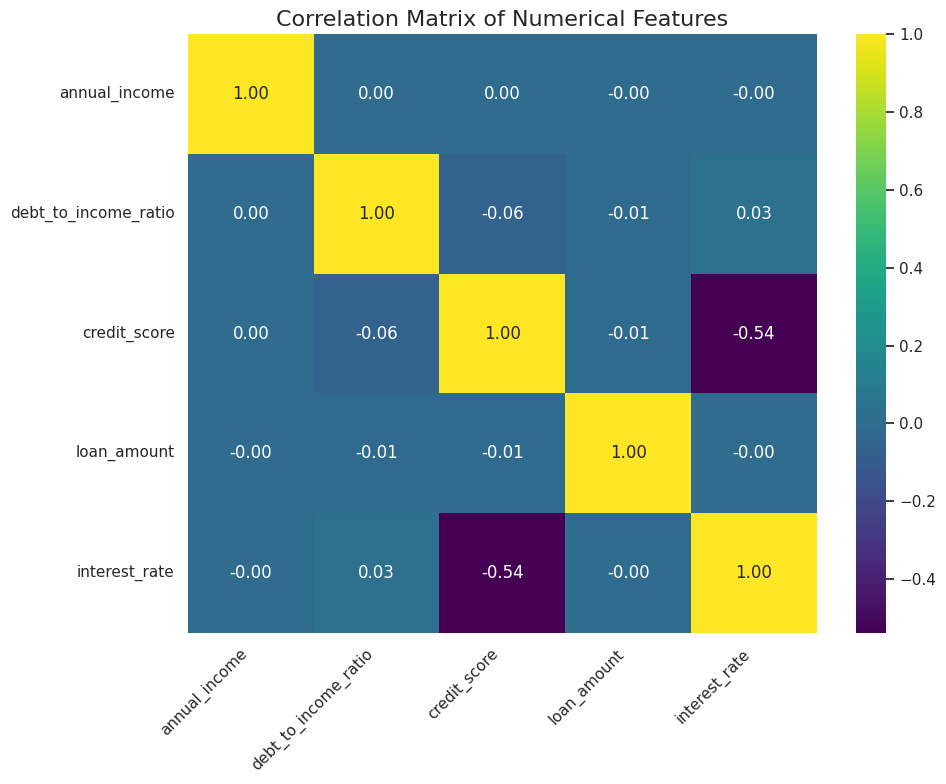

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for numerical features
correlation_matrix = df_train[numerical_features].corr()

# Create a heatmap
plt.figure(figsize=(10, 8)) # Adjust figure size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 2.4 Numerical Feature Distributions (Train vs Test)


📌 annual_income Summary Statistics:


,Train,Test
Mean,48212.202976,48233.080193
Median,46557.680000,46528.980000
Std,26711.942078,26719.658580


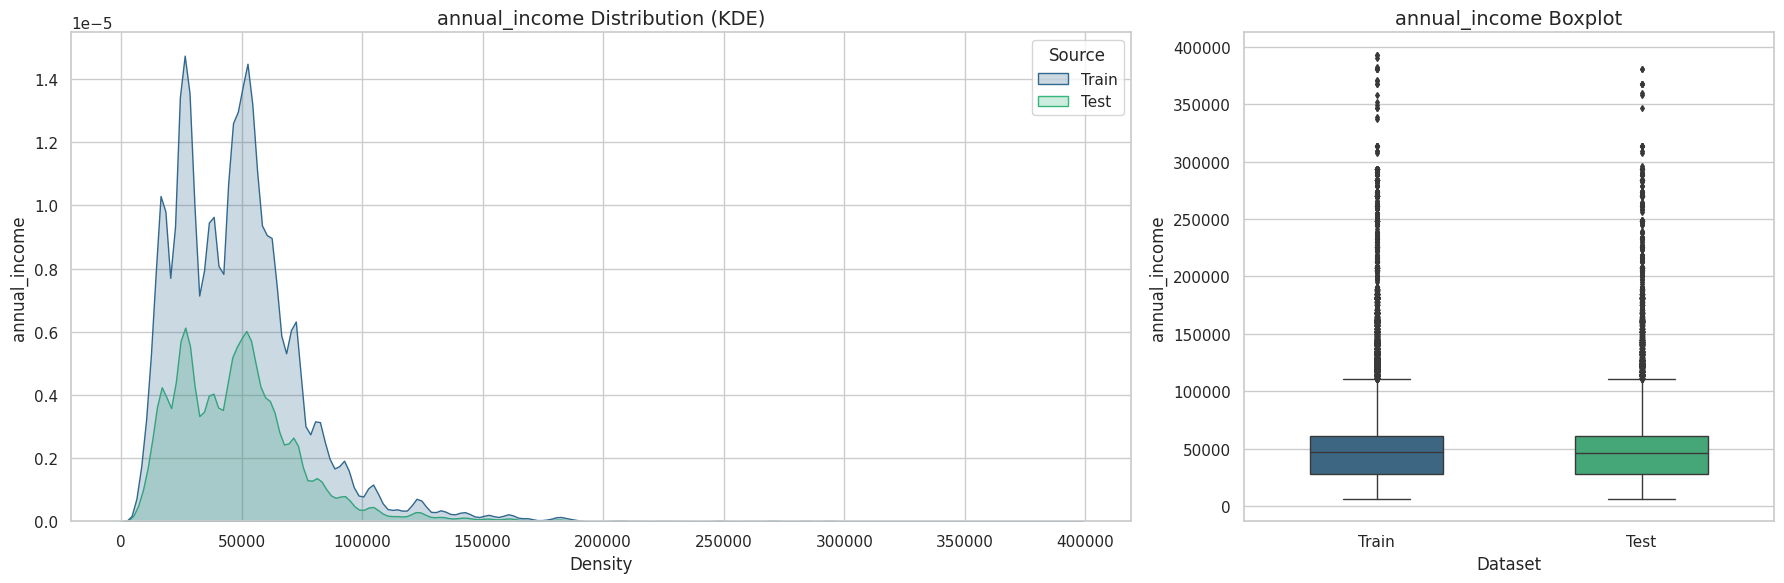


📌 debt_to_income_ratio Summary Statistics:


,Train,Test
Mean,0.120696,0.120583
Median,0.096000,0.096000
Std,0.068573,0.068582


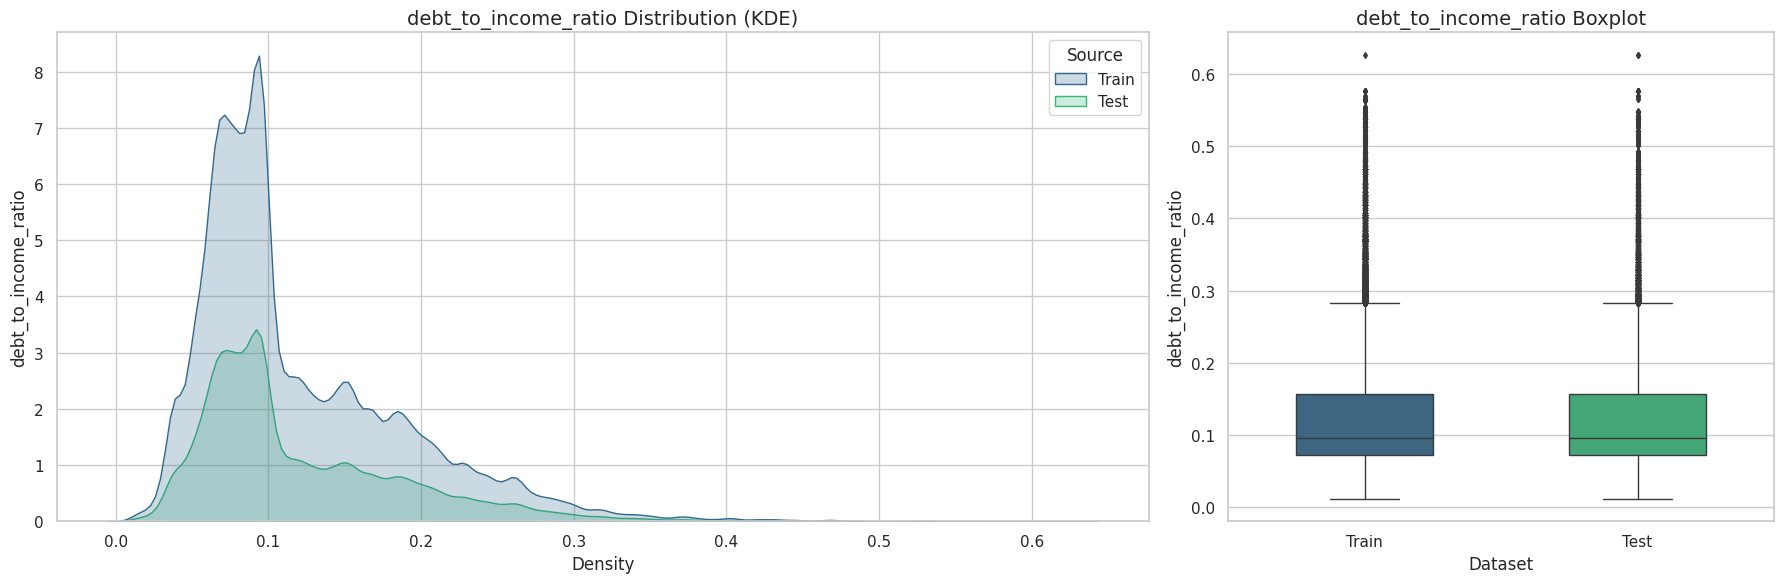


📌 credit_score Summary Statistics:


,Train,Test
Mean,680.916009,681.037691
Median,682.000000,683.000000
Std,55.424956,55.624118


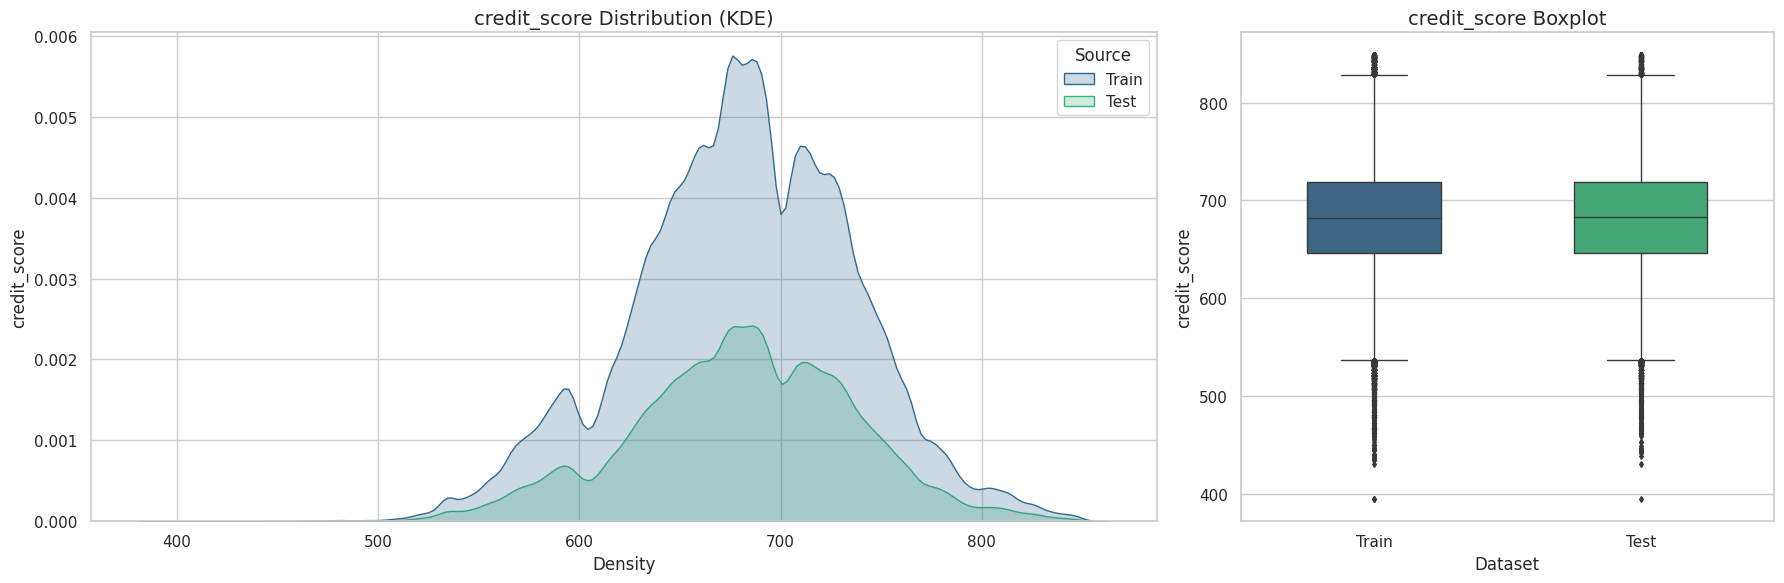


📌 loan_amount Summary Statistics:


,Train,Test
Mean,15020.297629,15016.753484
Median,15000.220000,15000.220000
Std,6926.530568,6922.165182


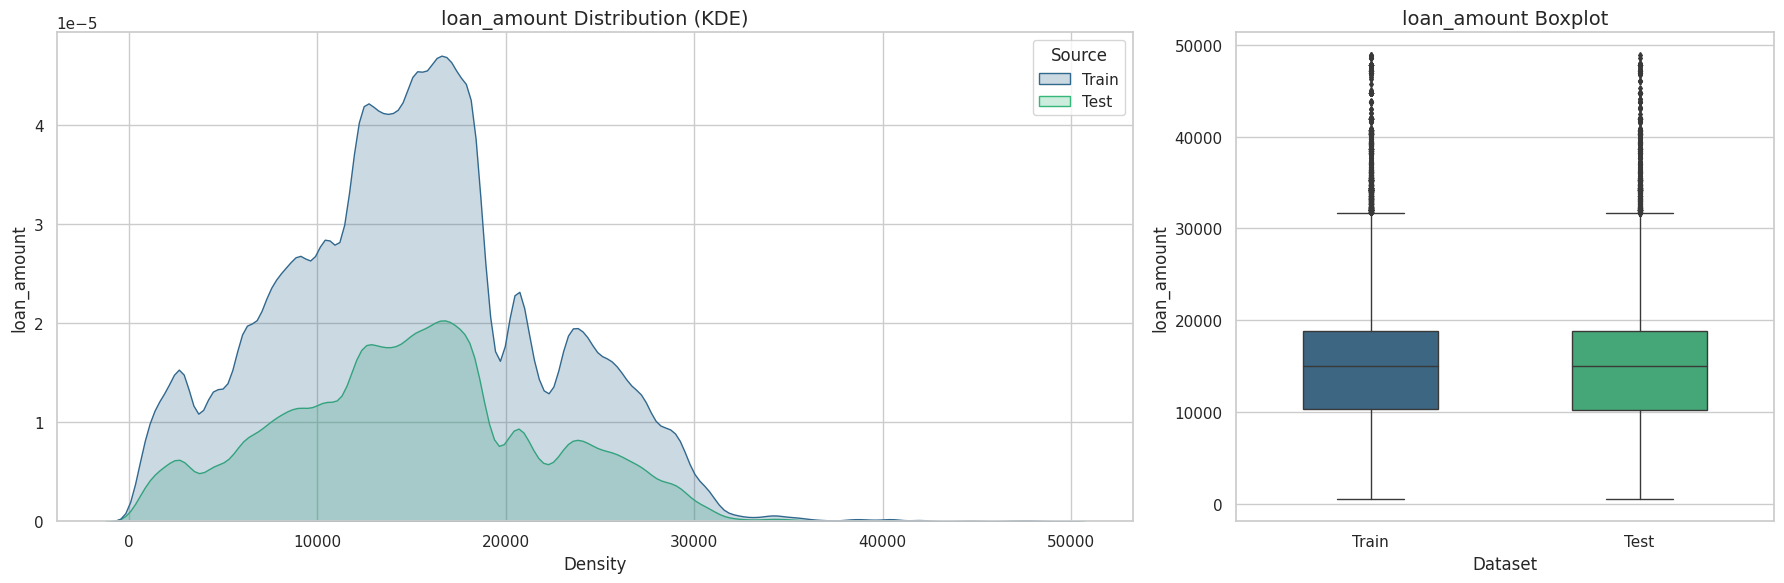


📌 interest_rate Summary Statistics:


,Train,Test
Mean,12.356345,12.352323
Median,12.370000,12.370000
Std,2.008959,2.017602


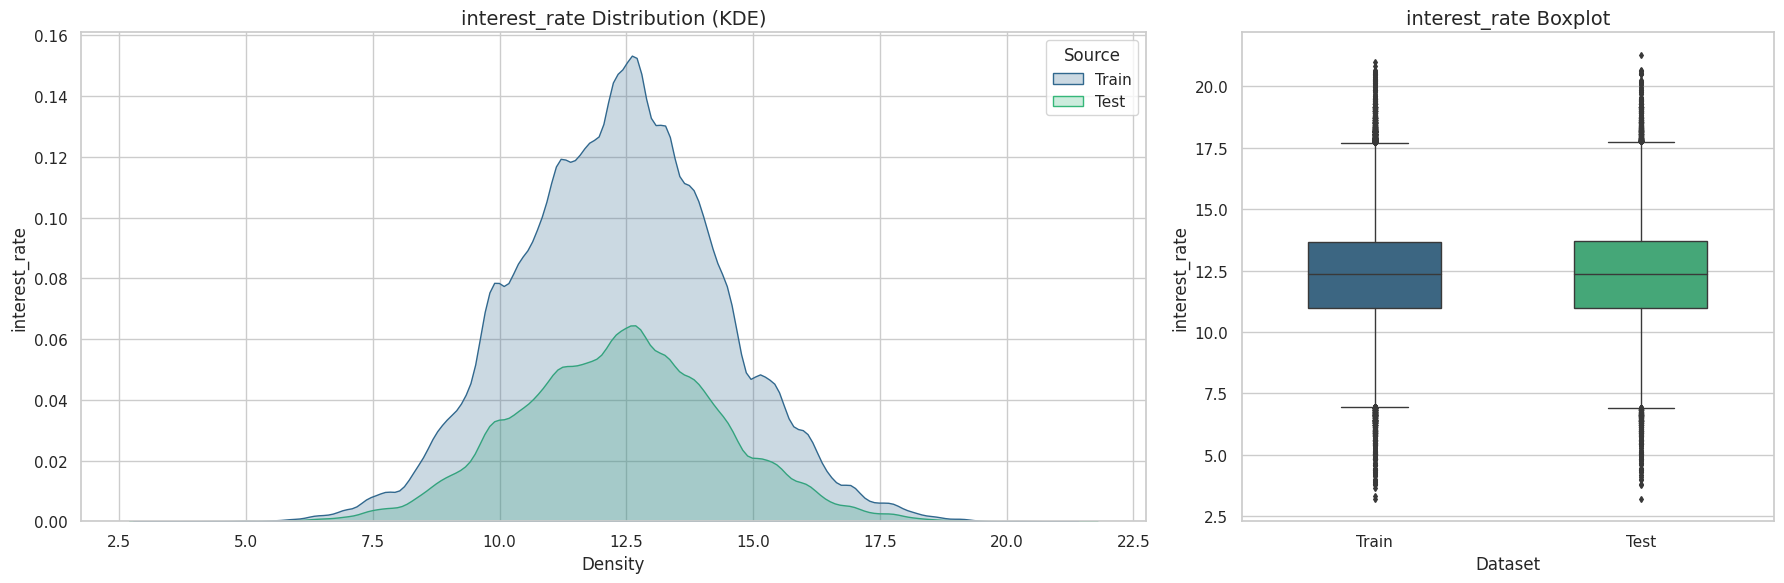

In [14]:
def plot_numerical_distributions(train_df, test_df, numerical_cols):
    """
    Generates KDE and box plots for numerical features, comparing train vs test distributions,
    with summary statistics printed.
    """
    sns.set_style("whitegrid")
    sns.set_context("notebook")

    # Combine train and test for plotting
    combined_df = pd.concat([
        train_df[numerical_cols].assign(Source='Train'),
        test_df[numerical_cols].assign(Source='Test')
    ], axis=0, ignore_index=True)

    palette = ['#1f77b4', '#ff7f0e']  # Distinct colors for Train/Test

    for col in numerical_cols:
        # Summary Stats
        print(f"\n📌 {col} Summary Statistics:")
        display(pd.DataFrame({
            'Train': [train_df[col].mean(), train_df[col].median(), train_df[col].std()],
            'Test': [test_df[col].mean(), test_df[col].median(), test_df[col].std()]
        }, index=['Mean', 'Median', 'Std']))

        fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1]})

        # KDE Plot
        sns.kdeplot(
            data=combined_df, x=col, hue='Source', ax=axes[0], fill=True, palette="viridis"
        )
        axes[0].set_title(f'{col} Distribution (KDE)', fontsize=14)
        axes[0].set_xlabel('Density')
        axes[0].set_ylabel(col)

        # Box Plot
        sns.boxplot(
            data=combined_df, y=col, x='Source', ax=axes[1],
            orient='v', width=0.5, linewidth=1, fliersize=3, palette="viridis"
        )
        axes[1].set_title(f'{col} Boxplot', fontsize=14)
        axes[1].set_xlabel('Dataset')
        axes[1].set_ylabel(col)

        plt.tight_layout()
        plt.show()

# Call numerical distribution function
plot_numerical_distributions(df_train, df_test, numerical_features)

## 2.5 Categorical Feature Distributions (Train vs Test)

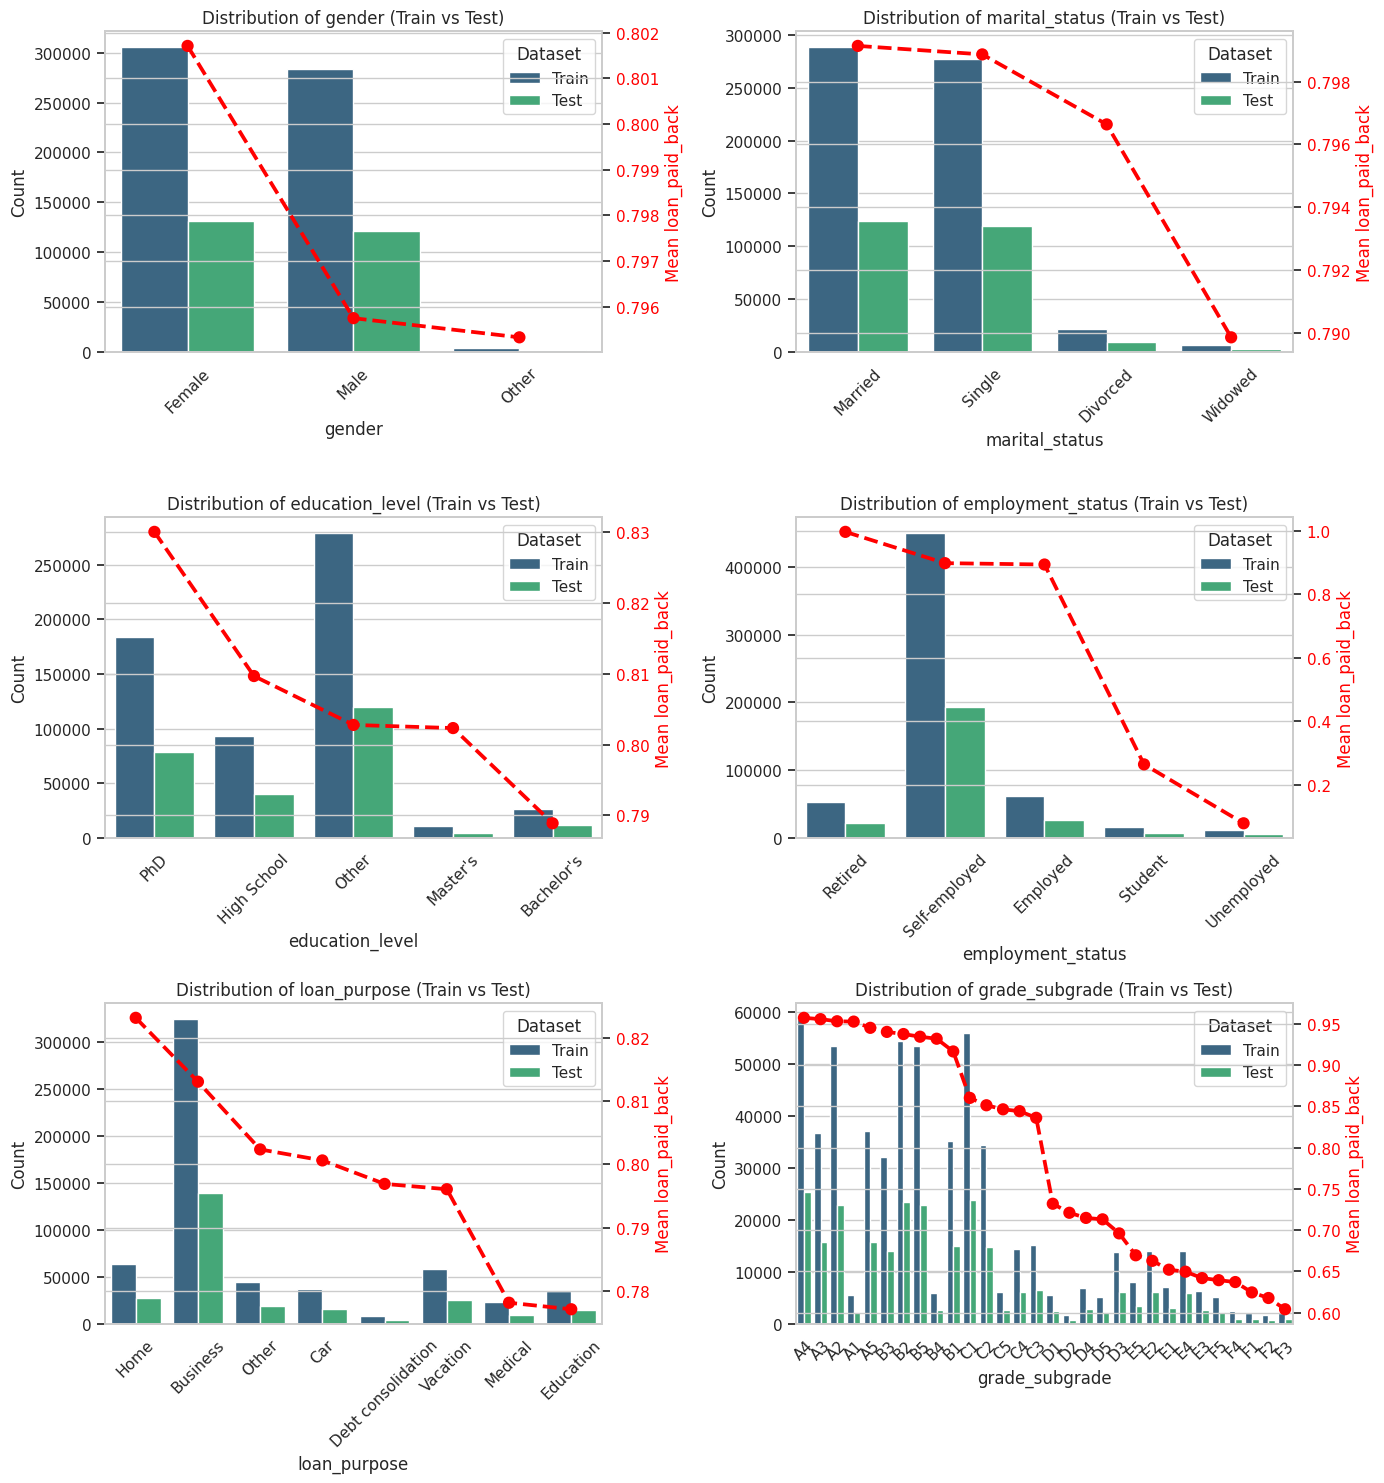

In [15]:
def plot_categorical_distributions(train_df, test_df, categorical_cols, target='loan_paid_back'):
    """
    Generates count plots for each categorical feature (train vs test)
    and bar plots showing mean target per category.
    Uses a denser layout with 2 plots per row.
    """
    if len(categorical_cols) == 0:
        print("No categorical features to plot.")
        return

    palette = ['#1f77b4', '#ff7f0e']  # Train / Test colors
    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
    axes = axes.flatten()  # Flatten axes array for easy iteration

    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        # Combine train and test for countplots
        combined = pd.concat([
            train_df[[col]].assign(Source='Train'),
            test_df[[col]].assign(Source='Test')
        ], axis=0, ignore_index=True)

        sns.countplot(x=col, hue='Source', data=combined, palette="viridis", ax=ax)
        ax.set_title(f'Distribution of {col} (Train vs Test)', fontsize=12)
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.legend(title='Dataset')
        ax.tick_params(axis='x', rotation=45)

        # Overlay mean target per category as a line/barplot
        target_means = train_df.groupby(col)[target].mean().sort_values(ascending=False)
        ax2 = ax.twinx()
        sns.pointplot(x=target_means.index, y=target_means.values, ax=ax2, color='red', markers='o', linestyles='--')
        ax2.set_ylabel(f'Mean {target}', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the enhanced function
plot_categorical_distributions(df_train, df_test, categorical_features, target='loan_paid_back')

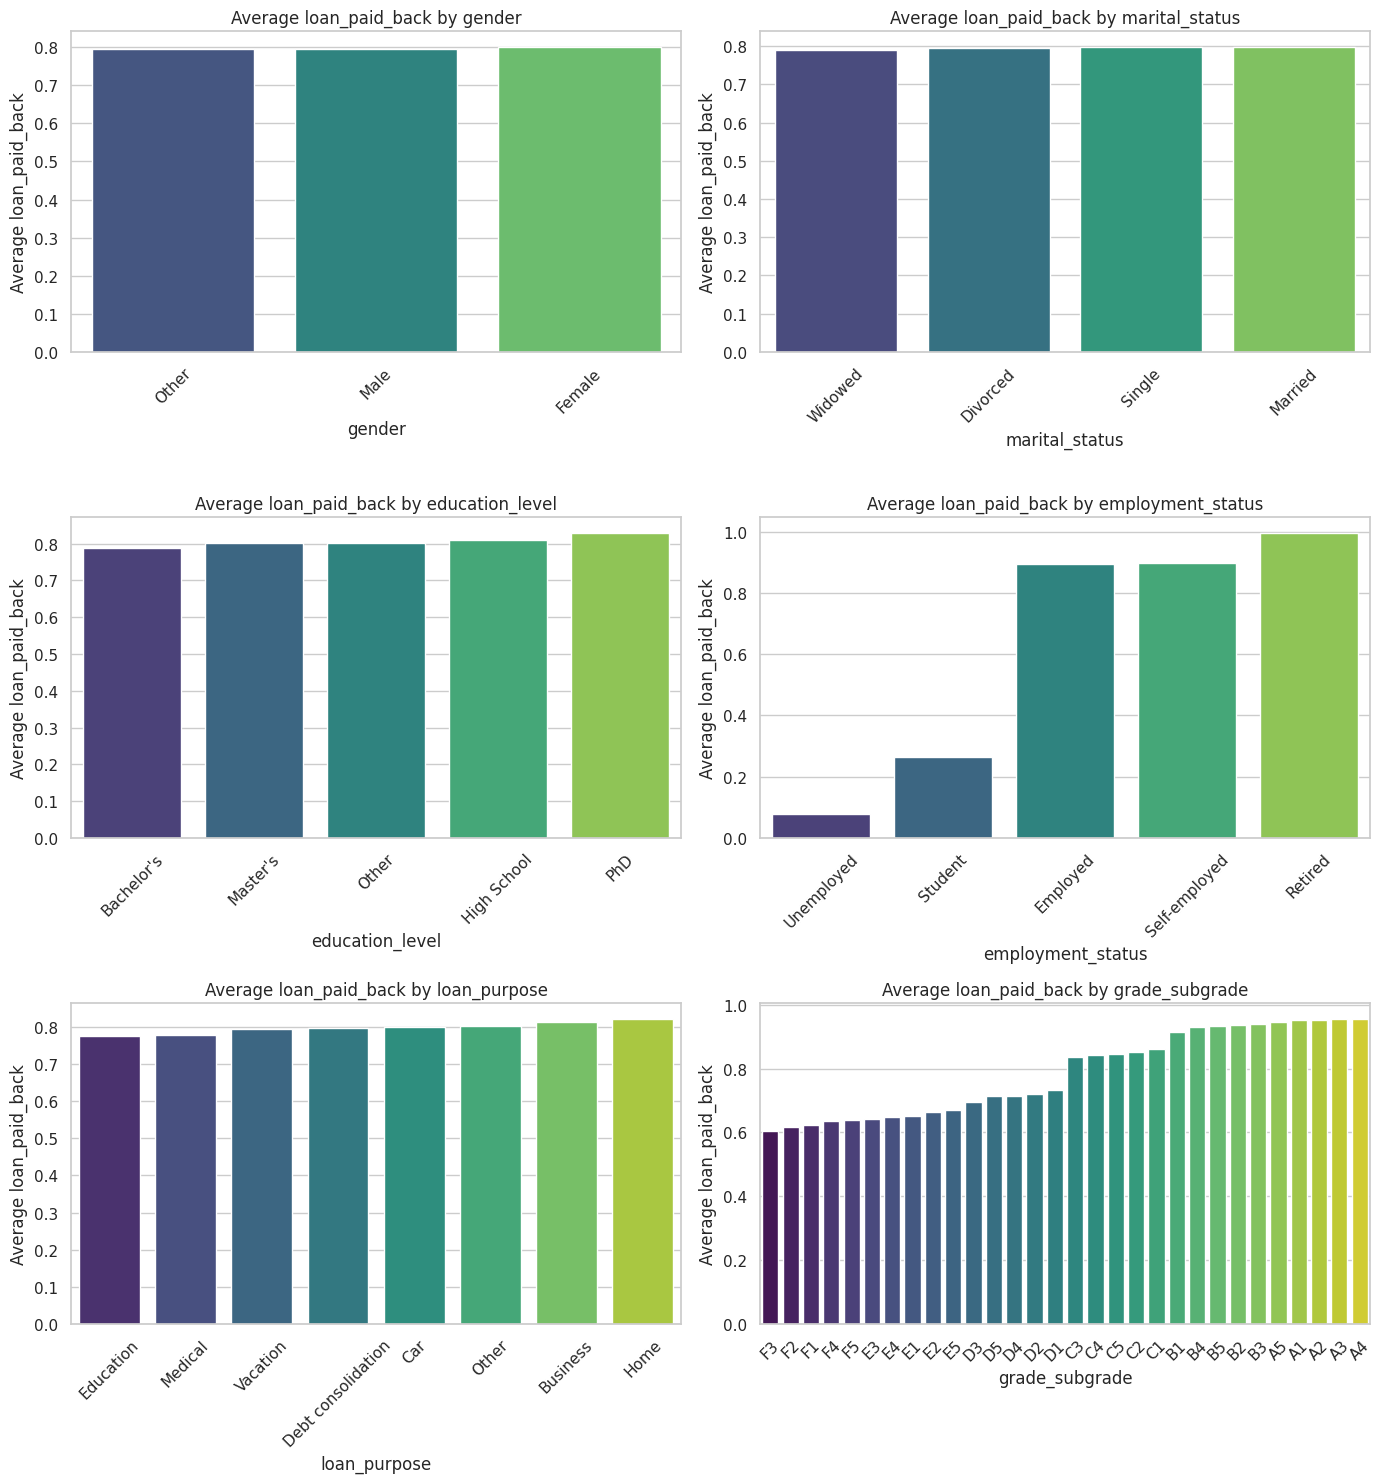

In [16]:
def plot_average_risk_by_category(train_df, categorical_cols, target_col):
    """
    Generates bar plots showing the average target value for each category
    in the specified categorical columns.
    """
    if len(categorical_cols) == 0:
        print("No categorical features to plot.")
        return

    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
    axes = axes.flatten() # Flatten the axes array

    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        # Calculate average target value per category
        avg_risk = train_df.groupby(col)[target_col].mean().sort_values()

        sns.barplot(x=avg_risk.index, y=avg_risk.values, ax=ax, palette='viridis')

        ax.set_title(f'Average {target_col} by {col}', fontsize=12)
        ax.set_xlabel(col)
        ax.set_ylabel(f'Average {target_col}')
        ax.tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the function
plot_average_risk_by_category(df_train, categorical_features, 'loan_paid_back')

# 3. Feature Engineering & Preprocessing

In [17]:


# --- 3. Define variables ---
print("\n--- Defining Feature Sets ---")
TARGET = 'loan_paid_back' # Corrected target column name based on sample_submission

# Ensure TARGET column exists in df_train before proceeding
if TARGET not in df_train.columns:
    print(f"Error: Target column '{TARGET}' not found in df_train. Please verify the target column name.")
    # Exit or handle this error as appropriate for your workflow
else:
    # BASE = all columns from df_train except 'id' and TARGET
    global BASE
    BASE = [col for col in df_train.columns if col not in ['id', TARGET]]

    # CATS = specified categorical features, filtered to ensure they are in BASE
    CATS_SPECIFIED = ['gender','marital_status','education_level','employment_status','loan_purpose','grade_subgrade']
    CATS = [c for c in CATS_SPECIFIED if c in BASE]

    # NUMS = all non-categorical columns in BASE
    NUMS = [col for col in BASE if col not in CATS]

    print(f"Target variable: '{TARGET}'")
    print(f"Total base features (excluding 'id' and target): {len(BASE)} columns")
    print(f"Categorical base features used for engineering: {len(CATS)} columns")
    print(f"Numerical base features: {len(NUMS)} columns")

    # --- 4. Create orig-based statistical features for both train and test ---
    print("\n--- Creating Orig-based Statistical Features ---")

    # Check if TARGET exists in df_orig before creating orig-based features
    if TARGET not in df_orig.columns:
        print(f"Warning: Target column '{TARGET}' not found in df_orig. Skipping 'orig-based statistical features' creation.")
    else:
        initial_train_cols = df_train.shape[1]
        initial_test_cols = df_test.shape[1]
        
        global ORIG_STATS
        ORIG_STATS = [] # Initialize ORIG_STATS globally
        agg_funcs = ['mean', 'std', 'min', 'max', 'median'] # Statistical functions to compute
        
        for col in BASE:
            # Ensure the column exists in df_orig before performing operations
            if col not in df_orig.columns:
                print(f"Warning: Column '{col}' from BASE not found in df_orig. Skipping feature creation for this column.")
                continue
            
            # --- Statistical features: mean, std, min, max, median of TARGET grouped by 'col' ---
            # Compute aggregates from df_orig
            stats_df = df_orig.groupby(col)[TARGET].agg(agg_funcs).reset_index()
            
            # Rename the new columns according to the specified format
            new_stat_col_names = [f'orig_{func}_{col}' for func in agg_funcs]
            stats_df.columns = [col] + new_stat_col_names
            
            # Merge these features into df_train and df_test using left merge
            df_train = df_train.merge(stats_df, on=col, how='left')
            df_test = df_test.merge(stats_df, on=col, how='left')
            
            ORIG_STATS.extend(new_stat_col_names)
            
            # --- Count feature: count of each value in 'col' in df_orig ---
            # Compute value counts from df_orig
            counts_df = df_orig[col].value_counts().reset_index(name=f'orig_count_{col}')
            counts_df.columns = [col, f'orig_count_{col}'] # Ensure correct column names after reset_index
            
            # Merge this count feature into df_train and df_test using left merge
            df_train = df_train.merge(counts_df, on=col, how='left')
            df_test = df_test.merge(counts_df, on=col, how='left')
            
            ORIG_STATS.append(f'orig_count_{col}')
        
        # --- 5. After feature creation ---
        print("\n--- Feature Creation Summary ---")
        print(f"Number of new features added: {len(ORIG_STATS)}")
        print(f"Updated shape of df_train: {df_train.shape}")
        print(f"Updated shape of df_test: {df_test.shape}")


--- Defining Feature Sets ---
Target variable: 'loan_paid_back'
Total base features (excluding 'id' and target): 11 columns
Categorical base features used for engineering: 6 columns
Numerical base features: 5 columns

--- Creating Orig-based Statistical Features ---

--- Feature Creation Summary ---
Number of new features added: 66
Updated shape of df_train: (593994, 79)
Updated shape of df_test: (254569, 78)


In [18]:
# =============================================================================
# STEP 1: Enhanced Financial Features
# =============================================================================
print("\n[STEP 1] Creating Enhanced Financial Features...")

def create_advanced_features(df):
    # Core affordability
    df['income_loan_ratio'] = df['annual_income'] / (df['loan_amount'] + 1)
    df['loan_to_income'] = df['loan_amount'] / (df['annual_income'] + 1)

    # Debt metrics
    df['total_debt'] = df['debt_to_income_ratio'] * df['annual_income']
    df['available_income'] = df['annual_income'] * (1 - df['debt_to_income_ratio'])
    df['debt_burden'] = df['debt_to_income_ratio'] * df['loan_amount']

    # Payment analysis
    df['monthly_payment'] = df['loan_amount'] * df['interest_rate'] / 1200
    df['payment_to_income'] = df['monthly_payment'] / (df['annual_income'] / 12 + 1)
    df['affordability'] = df['available_income'] / (df['loan_amount'] + 1)

    # Risk scoring
    df['default_risk'] = (df['debt_to_income_ratio'] * 0.40 +
                          (850 - df['credit_score']) / 850 * 0.35 +
                          df['interest_rate'] / 100 * 0.25)

    # Credit analysis
    df['credit_utilization'] = df['credit_score'] * (1 - df['debt_to_income_ratio'])
    df['credit_interest_product'] = df['credit_score'] * df['interest_rate'] / 100

    # Log transformations
    for col in ['annual_income', 'loan_amount']:
        df[f'{col}_log'] = np.log1p(df[col])

    # Grade parsing
    df['grade_letter'] = df['grade_subgrade'].str[0]
    df['grade_number'] = df['grade_subgrade'].str[1].astype(int)
    grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
    df['grade_rank'] = df['grade_letter'].map(grade_map)

    return df

df_train = create_advanced_features(df_train)
df_test = create_advanced_features(df_test)

NEW_FEATURES = ['income_loan_ratio', 'loan_to_income', 'total_debt',
                'available_income', 'debt_burden', 'monthly_payment',
                'payment_to_income', 'affordability', 'default_risk',
                'credit_utilization', 'credit_interest_product',
                'annual_income_log', 'loan_amount_log', 'grade_letter',
                'grade_number', 'grade_rank']

print(f"Created {len(NEW_FEATURES)} new features")


[STEP 1] Creating Enhanced Financial Features...
Created 16 new features


In [19]:
# =============================================================================
# STEP 2: Categorical Feature Engineering
# =============================================================================
print("\n[STEP 2] Engineering Categorical Features...")

# Define target and base features (assuming original columns before custom features)
target = 'loan_status'

NUMS_BASE = [
    'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'loan_term'
]
CATS_BASE = [
    'gender','employment_status', 'marital_status', 'education_level',
    'loan_purpose',  'grade_subgrade'
] # Removed 'housing_status'

# Create a combined DataFrame for feature engineering
# Store original lengths to split back later
len_train = len(df_train)
len_test = len(df_test)

# Ensure 'loan_status' is in df_test with NaNs for concatenation
df_test_temp = df_test.copy()
df_test_temp[target] = np.nan

combine = pd.concat([df_train, df_test_temp], ignore_index=True)

CATS = CATS_BASE.copy()
NUMS = NUMS_BASE + [f for f in NEW_FEATURES if f not in ['grade_letter']]
CATS.append('grade_letter')

# Create factorized versions of numerics
CATS_NUM = []
SIZES = {}

# Ensure all columns in NUMS exist in combine before factorizing
NUMS_existing = [col for col in NUMS if col in combine.columns]
for c in NUMS_existing:
    n = f"{c}_cat"
    CATS_NUM.append(n)
    combine[n], _ = combine[c].factorize()
    SIZES[n] = combine[n].max() + 1
    combine[n] = combine[n].astype('int32')

print(f"Created {len(CATS_NUM)} categorical numeric features")

# Create 2-way interactions (selective)
important_pairs = [
    ('employment_status', 'grade_subgrade'),
    ('employment_status', 'education_level'),
    ('employment_status', 'loan_purpose'),
    ('grade_subgrade', 'loan_purpose'),
    ('grade_subgrade', 'education_level'),
    ('marital_status', 'employment_status'),
]

# Add numeric cat interactions
numeric_cat_cols_for_interaction = [f"{col}_cat" for col in ['credit_score', 'debt_to_income_ratio', 'interest_rate'] if f"{col}_cat" in combine.columns]

for num_cat in numeric_cat_cols_for_interaction:
    for cat in ['employment_status', 'grade_subgrade']:
        if cat in combine.columns:
            important_pairs.append((num_cat, cat))

CATS_INTER = []
for c1, c2 in important_pairs:
    name = f"{c1}_{c2}"
    # Ensure both columns exist before creating interaction
    if c1 in combine.columns and c2 in combine.columns:
        combine[name] = combine[c1].astype(str) + '_' + combine[c2].astype(str)
        CATS_INTER.append(name)

print(f"Created {len(CATS_INTER)} strategic interactions")

# Count encoding
CE = []
ALL_CATS = CATS + CATS_NUM + CATS_INTER

print(f"\nCreating count encoding for {len(ALL_CATS)} categorical features...")
for i, c in enumerate(ALL_CATS):
    if i % 20 == 0:
        print(f"  Progress: {i}/{len(ALL_CATS)}")
    # Only proceed if the column exists in combine
    if c in combine.columns:
        # Ensure target column is present before groupby count
        if target in combine.columns:
            tmp = combine.groupby(c)[target].transform('count') # Use transform to get series back with original index
            tmp.name = f"CE_{c}"
            CE.append(f"CE_{c}")
            combine = combine.merge(tmp, left_index=True, right_index=True, how='left') # Merge based on index
        else:
            print(f"Warning: Target column '{target}' not found in combine DataFrame. Skipping count encoding for '{c}'.")
    else:
        print(f"Warning: Column '{c}' not found in combine DataFrame. Skipping count encoding for this column.")

print(f"Created {len(CE)} count encodings")

# Split back
train = combine.iloc[:len_train].copy()
test = combine.iloc[len_train:len_train + len_test].copy()

print(f"\nTrain: {train.shape}, Test: {test.shape}")


[STEP 2] Engineering Categorical Features...
Created 20 categorical numeric features
Created 12 strategic interactions

Creating count encoding for 39 categorical features...
  Progress: 0/39
  Progress: 20/39
Created 39 count encodings

Train: (593994, 167), Test: (254569, 167)


In [20]:
import itertools
import pandas as pd
import numpy as np

class InteractionFeatureGenerator:
    def __init__(self, base_features, three_way_triplets):
        self.base_features = base_features
        self.three_way_triplets = three_way_triplets

    def _create_interaction_feature(self, df, cols, name):
        """Helper to create a single interaction feature."""
        # Ensure all columns exist in the dataframe before proceeding
        if all(c in df.columns for c in cols):
            df[name] = df[cols[0]].astype(str)
            for col in cols[1:]:
                df[name] += '_' + df[col].astype(str)
            return True
        return False

    def generate(self, train, test, orig):
        created_features = []
        two_way_count = 0
        three_way_count = 0

        # --- Generate 2-way interaction features (bigrams) ---
        for col1, col2 in itertools.combinations(self.base_features, 2):
            feature_name = f"{col1}_{col2}"

            # Apply to train
            if self._create_interaction_feature(train, [col1, col2], feature_name):
                _ = self._create_interaction_feature(test, [col1, col2], feature_name) # Apply to test
                _ = self._create_interaction_feature(orig, [col1, col2], feature_name) # Apply to orig
                created_features.append(feature_name)
                two_way_count += 1

        print(f"Created {two_way_count} 2-way interaction features.")

        # --- Generate 3-way interaction features ---
        for triplet in self.three_way_triplets:
            col1, col2, col3 = triplet
            feature_name = f"{col1}_{col2}_{col3}"

            # Apply to train
            if self._create_interaction_feature(train, [col1, col2, col3], feature_name):
                _ = self._create_interaction_feature(test, [col1, col2, col3], feature_name) # Apply to test
                _ = self._create_interaction_feature(orig, [col1, col2, col3], feature_name) # Apply to orig
                created_features.append(feature_name)
                three_way_count += 1

        print(f"Created {three_way_count} 3-way interaction features.")

        return train, test, orig, created_features


# --- Example Usage ---

# Assuming BASE is already defined from previous steps
# BASE = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']

TE_BASE = [col for col in BASE if col not in ['annual_income','loan_amount']]
triplets = [
    ('grade_subgrade','employment_status','loan_purpose'),
    ('grade_subgrade','debt_to_income_ratio','credit_score'),
    ('loan_purpose','education_level','marital_status')
]

gen = InteractionFeatureGenerator(TE_BASE, triplets)

# Ensure train, test, and orig DataFrames exist from previous steps
# For demonstration purposes, we'll assume they are available from the kernel state.

train, test, orig, inter_feats_local = gen.generate(df_train, df_test, df_orig)

# Make INTER and INTER_3WAY global
global INTER_3WAY
global INTER

INTER_3WAY = [f"{t[0]}_{t[1]}_{t[2]}" for t in triplets]
INTER = [f for f in inter_feats_local if f not in INTER_3WAY]

print(f"\nTotal interaction features created: {len(inter_feats_local)}")
print("Updated shapes after interaction feature creation:")
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")
print(f"Orig: {orig.shape}")

Created 36 2-way interaction features.
Created 3 3-way interaction features.

Total interaction features created: 39
Updated shapes after interaction feature creation:
Train: (593994, 134)
Test: (254569, 133)
Orig: (20000, 61)


In [21]:
# ───────────────────────────────────
# 3) QUANTILE FEATURES
# ───────────────────────────────────
print("\n[3/4] Quantile Features...")
global QFEAT
QFEAT = []
for col in ['annual_income', 'loan_amount', 'credit_score']:
    quantiles = np.percentile(train[col], np.arange(0, 101, 5))
    qcol = f'{col}_quantile'
    train[qcol] = np.digitize(train[col], quantiles)
    test[qcol] = np.digitize(test[col], quantiles)
    orig[qcol] = np.digitize(orig[col], quantiles)
    QFEAT.append(qcol)

print(f"✓ Created {len(QFEAT)} quantile features")

# ───────────────────────────────────
# 4) ROUNDING FEATURES
# ───────────────────────────────────
print("\n[4/4] Rounding Features...")
global ROUND
ROUND = []
rounding_levels = {'1s': 0, '10s': -1, '100s': -2}

for col in ['annual_income', 'loan_amount']:
    for suffix, level in rounding_levels.items():
        new_col = f"{col}_ROUND_{suffix}"
        ROUND.append(new_col)
        for df in [train, test, orig]:
            df[new_col] = df[col].round(level).astype(int)

print(f"✓ Created {len(ROUND)} rounding features")

# ───────────────────────────────────
# FINAL FEATURE LIST
# ───────────────────────────────────
global ALL_FEATS
ALL_FEATS = BASE + ORIG_STATS + QFEAT + INTER + INTER_3WAY + ROUND
print(f"\n✅ Total Features: {len(ALL_FEATS)}")


[3/4] Quantile Features...
✓ Created 3 quantile features

[4/4] Rounding Features...
✓ Created 6 rounding features

✅ Total Features: 125


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

class TargetEncoder:
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth=1.0, drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_agg_stats_ = {}
        self.global_mean_for_smoothing_ = None

    def _calculate_global_mean_for_smoothing(self, y):
        return y.mean()

    def _calculate_global_agg_stats(self, y):
        global_agg_stats = {}
        for agg in self.aggs:
            if agg == 'mean':
                global_agg_stats[agg] = y.mean()
            elif agg == 'std':
                global_agg_stats[agg] = y.std()
            elif agg == 'min':
                global_agg_stats[agg] = y.min()
            elif agg == 'max':
                global_agg_stats[agg] = y.max()
            elif agg == 'median':
                global_agg_stats[agg] = y.median()
            # Add other aggregations as needed
        return global_agg_stats

    def _calculate_fold_mapping(self, X_subset, y_subset, col, fold_global_mean_for_smoothing):
        col_mappings = {}
        temp_df = X_subset[[col]].copy()
        temp_df['target'] = y_subset

        for agg in self.aggs:
            if agg == 'mean':
                agg_df = temp_df.groupby(col)['target'].agg(['mean', 'count'])
                smoothed_mean = (agg_df['count'] * agg_df['mean'] + self.smooth * fold_global_mean_for_smoothing) / (agg_df['count'] + self.smooth)
                col_mappings[agg] = smoothed_mean
            else:
                col_mappings[agg] = temp_df.groupby(col)['target'].agg(agg)
        return col_mappings

    def fit(self, X, y):
        self.global_mean_for_smoothing_ = self._calculate_global_mean_for_smoothing(y)
        self.global_agg_stats_ = self._calculate_global_agg_stats(y)

        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            temp_df = X[[col]].copy()
            temp_df['target'] = y
            
            for agg in self.aggs:
                if agg == 'mean':
                    agg_df = temp_df.groupby(col)['target'].agg(['mean', 'count'])
                    smoothed_mean = (agg_df['count'] * agg_df['mean'] + self.smooth * self.global_mean_for_smoothing_) / (agg_df['count'] + self.smooth)
                    self.mappings_[col][agg] = smoothed_mean
                else:
                    self.mappings_[col][agg] = temp_df.groupby(col)['target'].agg(agg)
        return self

    def transform(self, X):
        X_transformed = X.copy()
        
        for col in self.cols_to_encode:
            for agg in self.aggs:
                new_col_name = f"TE_{col}_{agg}"
                fill_value = self.global_agg_stats_.get(agg, np.nan)
                X_transformed[new_col_name] = X_transformed[col].map(self.mappings_[col][agg]).fillna(fill_value)
                
            if self.drop_original:
                X_transformed = X_transformed.drop(columns=[col])

        return X_transformed

    def fit_transform(self, X, y):
        X_transformed = X.copy()
        
        self.global_mean_for_smoothing_ = self._calculate_global_mean_for_smoothing(y)
        self.global_agg_stats_ = self._calculate_global_agg_stats(y)

        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for col in self.cols_to_encode:
            for agg in self.aggs:
                new_col_name = f"TE_{col}_{agg}"
                X_transformed[new_col_name] = np.nan

        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]

            fold_global_mean_for_smoothing = self._calculate_global_mean_for_smoothing(y_train_fold)

            for col in self.cols_to_encode:
                fold_col_mappings = self._calculate_fold_mapping(X_train_fold, y_train_fold, col, fold_global_mean_for_smoothing)

                for agg in self.aggs:
                    new_col_name = f"TE_{col}_{agg}"
                    fill_value_for_agg = self.global_agg_stats_.get(agg, np.nan)
                    X_transformed.loc[val_idx, new_col_name] = X_val_fold[col].map(fold_col_mappings[agg]).fillna(fill_value_for_agg)

        self.fit(X, y)

        if self.drop_original:
            X_transformed = X_transformed.drop(columns=self.cols_to_encode)

        return X_transformed

def fix_dtypes_for_lgb(df, categorical_cols):
    df_fixed = df.copy()
    
    # Convert explicitly listed categorical columns
    for col in categorical_cols:
        if col in df_fixed.columns:
            df_fixed[col] = df_fixed[col].astype('category')
            
    # Iterate through remaining object columns and try to convert/factorize
    for col in df_fixed.select_dtypes(include='object').columns:
        try:
            df_fixed[col] = df_fixed[col].astype('category')
        except:
            # If conversion to category fails (e.g., too many unique values), factorize
            df_fixed[col], _ = pd.factorize(df_fixed[col])
            df_fixed[col] = df_fixed[col].astype('int32')
                
    return df_fixed

# --- Example Usage ---
# Assuming CATS, TARGET, train, test are defined from previous steps

te = TargetEncoder(cols_to_encode=CATS, aggs=['mean'], cv=5, smooth=5)
train_te = te.fit_transform(train, train[TARGET])
test_te = te.transform(test)

train_fixed = fix_dtypes_for_lgb(train_te, CATS)
test_fixed = fix_dtypes_for_lgb(test_te, CATS)

print("Target Encoding and Dtype Fixing complete.")
print(f"Shape of train_fixed: {train_fixed.shape}")
print(f"Shape of test_fixed: {test_fixed.shape}")
print(f"First 5 rows of train_fixed.head():")
display(train_fixed.head())
print(f"First 5 rows of test_fixed.head():")
display(test_fixed.head())

Target Encoding and Dtype Fixing complete.
Shape of train_fixed: (593994, 150)
Shape of test_fixed: (254569, 149)
First 5 rows of train_fixed.head():


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,...,loan_amount_ROUND_1s,loan_amount_ROUND_10s,loan_amount_ROUND_100s,TE_gender_mean,TE_employment_status_mean,TE_marital_status_mean,TE_education_level_mean,TE_loan_purpose_mean,TE_grade_subgrade_mean,TE_grade_letter_mean
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,...,2528,2530,2500,0.802141,0.899935,0.798951,0.809686,0.802012,0.835335,0.847560
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,...,4593,4590,4600,0.795659,0.894200,0.799032,0.802114,0.796389,0.695862,0.715460
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,...,17005,17010,17000,0.795738,0.894131,0.798951,0.809686,0.797287,0.847437,0.847560
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,...,4682,4680,4700,0.802255,0.894268,0.799220,0.809998,0.797795,0.626549,0.627034
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,...,12184,12180,12200,0.795659,0.894200,0.799032,0.809370,0.802117,0.732256,0.715460


First 5 rows of test_fixed.head():


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,...,loan_amount_ROUND_1s,loan_amount_ROUND_10s,loan_amount_ROUND_100s,TE_gender_mean,TE_employment_status_mean,TE_marital_status_mean,TE_education_level_mean,TE_loan_purpose_mean,TE_grade_subgrade_mean,TE_grade_letter_mean
0,593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,...,11461,11460,11500,0.801708,0.894144,0.798873,0.809697,0.802376,0.713013,0.715337
1,593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,...,15492,15490,15500,0.801708,0.894144,0.799144,0.802346,0.802376,0.860085,0.847259
2,593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,...,3796,3800,3800,0.795752,0.894144,0.798873,0.788892,0.796911,0.731895,0.715337
3,593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,...,6574,6570,6600,0.801708,0.894144,0.798873,0.788892,0.796911,0.835996,0.847259
4,593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,...,17697,17700,17700,0.801708,0.894144,0.799144,0.830053,0.813102,0.860085,0.847259


# 4. Modeling

In [23]:
import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb # for early_stopping
import time # Import the time module

# ============================================================================
# TRAINING FUNCTION (FIXED FOR ALL MODELS)
# ============================================================================
def train_models(seed):
    """Train all 3 models with proper dtype handling"""

    print(f"\n{'─'*80}")
    print(f"SEED: {seed}")
    print(f"{'─'*80}")

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)

    X = train[ALL_FEATS].copy()
    y = train[TARGET].copy()
    Xt = test[ALL_FEATS].copy()

    # ──────────────────────────────────────────────────────
    # TARGET ENCODING
    # ──────────────────────────────────────────────────────
    print("Applying target encoding...")

    # Encode interactions (drop originals)
    te_inter = TargetEncoder(cols_to_encode=INTER + INTER_3WAY, cv=5,
                            smooth=1.0, drop_original=True)
    X = te_inter.fit_transform(X, y)
    Xt = te_inter.transform(Xt)

    # Encode round/quantile features (keep originals)
    te_round = TargetEncoder(cols_to_encode=ROUND + QFEAT, cv=5,
                            aggs=['mean'], drop_original=False)
    X = te_round.fit_transform(X, y)
    Xt = te_round.transform(Xt)

    print(f"✓ Features after TE: {X.shape[1]}")

    # ──────────────────────────────────────────────────────
    # [1/3] CATBOOST
    # ──────────────────────────────────────────────────────
    print("\n[1/3] Training CatBoost...")

    params_cat = {
        'iterations': 2500,
        'learning_rate': 0.02,
        'depth': 6,
        'l2_leaf_reg': 3.5,
        'random_strength': 2.0,
        'bagging_temperature': 0.5,
        'task_type': 'CPU', # Changed from 'GPU' to 'CPU'
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_seed': seed,
        'early_stopping_rounds': 150,
        'verbose': False
    }

    # Categorical columns for CatBoost
    # Ensure 'grade_letter' is included as it's a string categorical feature
    cat_cols_for_catboost = [c for c in CATS + QFEAT + ['grade_letter'] if c in X.columns]

    oof_cat = np.zeros(len(X))
    test_cat = np.zeros(len(Xt))

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        # Get indices of categorical features for the current fold
        cat_indices = [X.columns.get_loc(c) for c in cat_cols_for_catboost if c in X.columns]

        train_pool = Pool(X.iloc[tr], y.iloc[tr], cat_features=cat_indices)
        val_pool = Pool(X.iloc[va], y.iloc[va], cat_features=cat_indices)
        test_pool = Pool(Xt, cat_features=cat_indices)

        model_cat = CatBoostClassifier(**params_cat)
        model_cat.fit(train_pool, eval_set=val_pool)

        oof_cat[va] = model_cat.predict_proba(val_pool)[:, 1]
        test_cat += model_cat.predict_proba(test_pool)[:, 1] / N_SPLITS

        print(f"  Fold {fold}/{N_SPLITS} AUC: {roc_auc_score(y.iloc[va], oof_cat[va]):.5f}")

        del train_pool, val_pool, test_pool, model_cat
        gc.collect()

    cv_cat = roc_auc_score(y, oof_cat)
    print(f"CatBoost CV: {cv_cat:.5f}")

    # ──────────────────────────────────────────────────────
    # [2/3] XGBOOST
    # ──────────────────────────────────────────────────────
    print("\n[2/3] Training XGBoost...")

    params_xgb = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 6,
        'min_child_weight': 5,
        'colsample_bytree': 0.35,
        'colsample_bylevel': 0.65,
        'subsample': 0.70,
        'reg_alpha': 1.2,
        'reg_lambda': 4.5,
        'gamma': 0.4,
        'learning_rate': 0.008,
        'n_estimators': 15000,
        'early_stopping_rounds': 250,
        'random_state': seed,
        'n_jobs': -1,
        'enable_categorical': True,
        'device': 'cuda',
        'tree_method': 'hist'
    }

    oof_xgb = np.zeros(len(X))
    test_xgb = np.zeros(len(Xt))

    # Categorical columns for XGBoost
    # Ensure 'grade_letter' is included as it's a string categorical feature
    xgb_cat_cols = [c for c in CATS + QFEAT + ['grade_letter'] if c in X.columns]

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        X_train = X.iloc[tr].copy()
        y_train = y.iloc[tr]
        X_val = X.iloc[va].copy()
        y_val = y.iloc[va]
        Xt_copy = Xt.copy()

        # Convert categorical columns to 'category' dtype for XGBoost
        for cat_col in xgb_cat_cols:
            X_train[cat_col] = X_train[cat_col].astype('category')
            X_val[cat_col] = X_val[cat_col].astype('category')
            Xt_copy[cat_col] = Xt_copy[cat_col].astype('category')

        model_xgb = XGBClassifier(**params_xgb)
        model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        oof_xgb[va] = model_xgb.predict_proba(X_val)[:, 1]
        test_xgb += model_xgb.predict_proba(Xt_copy)[:, 1] / N_SPLITS

        print(f"  Fold {fold}/{N_SPLITS} AUC: {roc_auc_score(y_val, oof_xgb[va]):.5f}")

        del X_train, X_val, y_train, y_val, Xt_copy, model_xgb
        gc.collect()

    cv_xgb = roc_auc_score(y, oof_xgb)
    print(f"XGBoost CV: {cv_xgb:.5f}")

    # ──────────────────────────────────────────────────────
    # [3/3] LIGHTGBM (WITH CRITICAL FIX)
    # ──────────────────────────────────────────────────────
    print("\n[3/3] Training LightGBM...")

    params_lgb = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': 0.008,
        'num_leaves': 32,
        'max_depth': 6,
        'min_child_samples': 20,
        'subsample': 0.75,
        'subsample_freq': 1,
        'colsample_bytree': 0.35,
        'reg_alpha': 1.2,
        'reg_lambda': 5.5,
        'min_split_gain': 0.01,
        'random_state': seed,
        'device': 'gpu',
        'verbose': -1
    }

    oof_lgb = np.zeros(len(X))
    test_lgb = np.zeros(len(Xt))

    # LightGBM categorical columns
    # Ensure 'grade_letter' is included as it's a string categorical feature
    lgb_cat_cols = [c for c in CATS + QFEAT + ['grade_letter'] if c in X.columns]

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        X_train = X.iloc[tr].copy()
        y_train = y.iloc[tr]
        X_val = X.iloc[va].copy()
        y_val = y.iloc[va]
        Xt_copy = Xt.copy()

        # CRITICAL FIX: Convert dtypes for LightGBM
        X_train = fix_dtypes_for_lgb(X_train, lgb_cat_cols)
        X_val = fix_dtypes_for_lgb(X_val, lgb_cat_cols)
        Xt_copy = fix_dtypes_for_lgb(Xt_copy, lgb_cat_cols)

        model_lgb = LGBMClassifier(**params_lgb, n_estimators=12000)  #2000
        model_lgb.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(200, verbose=False)],
            categorical_feature=[c for c in lgb_cat_cols if c in X_train.columns]
        )

        oof_lgb[va] = model_lgb.predict_proba(X_val)[:, 1]
        test_lgb += model_lgb.predict_proba(Xt_copy)[:, 1] / N_SPLITS

        print(f"  Fold {fold}/{N_SPLITS} AUC: {roc_auc_score(y_val, oof_lgb[va]):.5f}")

        del X_train, X_val, y_train, y_val, Xt_copy, model_lgb
        gc.collect()

    cv_lgb = roc_auc_score(y, oof_lgb)
    print(f"LightGBM CV: {cv_lgb:.5f}")

    return oof_cat, test_cat, oof_xgb, test_xgb, oof_lgb, test_lgb

# --- Execution of the training function ---

# Define global variables needed by train_models
# N_SPLITS = 5 # This is already defined in the first setup cell. Do not redefine.

# The following variables are now defined globally in preceding cells:
# ALL_FEATS, INTER, INTER_3WAY, ROUND, QFEAT

# Call the training function

# print("\nStarting model training...")
# oof_cat, test_cat, oof_xgb, test_xgb, oof_lgb, test_lgb = train_models(SEED)

# print("\n--- Model Training Results ---")
# print(f"CatBoost OOF AUC: {roc_auc_score(train[TARGET], oof_cat):.5f}")
# print(f"XGBoost OOF AUC: {roc_auc_score(train[TARGET], oof_xgb):.5f}")
# print(f"LightGBM OOF AUC: {roc_auc_score(train[TARGET], oof_lgb):.5f}")

# # Final ensemble prediction (simple average)
# final_preds = (test_cat + test_xgb + test_lgb) / 3

# print("\n--- Final Submission Preview ---")
# submission = pd.DataFrame({'id': test['id'], TARGET: final_preds})
# print(submission.head())

# 5. Model Training

In [ ]:
# ============================================================================
# RUN TRAINING FOR ALL SEEDS
# ============================================================================
print("\n" + "="*80)
print("TRAINING MULTI-SEED ENSEMBLE")
print("="*80)



start_time = time.time()

oof_cats, test_cats = [], []
oof_xgbs, test_xgbs = [], []
oof_lgbs, test_lgbs = [], []

# Define SEED_LIST
SEED_LIST = [SEED]

for seed in SEED_LIST:
    out_cat, tst_cat, out_xgb, tst_xgb, out_lgb, tst_lgb = train_models(seed)

    oof_cats.append(out_cat)
    test_cats.append(tst_cat)
    oof_xgbs.append(out_xgb)
    test_xgbs.append(tst_xgb)
    oof_lgbs.append(out_lgb)
    test_lgbs.append(tst_lgb)


TRAINING MULTI-SEED ENSEMBLE

────────────────────────────────────────────────────────────────────────────────
SEED: 42
────────────────────────────────────────────────────────────────────────────────
Applying target encoding...
✓ Features after TE: 134

[1/3] Training CatBoost...
  Fold 1/7 AUC: 0.92794
  Fold 2/7 AUC: 0.92838


In [ ]:
# ============================================================================
# AVERAGE ACROSS SEEDS
# ============================================================================
print("\n" + "="*80)
print("AVERAGING PREDICTIONS ACROSS SEEDS")
print("="*80)

oof_cat_avg = np.mean(oof_cats, axis=0)
test_cat_avg = np.mean(test_cats, axis=0)
oof_xgb_avg = np.mean(oof_xgbs, axis=0)
test_xgb_avg = np.mean(test_xgbs, axis=0)
oof_lgb_avg = np.mean(oof_lgbs, axis=0)
test_lgb_avg = np.mean(test_lgbs, axis=0)

cv_cat_final = roc_auc_score(train[TARGET], oof_cat_avg)
cv_xgb_final = roc_auc_score(train[TARGET], oof_xgb_avg)
cv_lgb_final = roc_auc_score(train[TARGET], oof_lgb_avg)

print(f"CatBoost Multi-Seed CV: {cv_cat_final:.5f}")
print(f"XGBoost Multi-Seed CV:  {cv_xgb_final:.5f}")
print(f"LightGBM Multi-Seed CV: {cv_lgb_final:.5f}")

In [ ]:
from scipy.optimize import minimize

# ============================================================================
# FINAL ENSEMBLE
# ============================================================================
print("\n" + "="*80)
print("OPTIMIZING FINAL ENSEMBLE")
print("="*80)

# Simple average
oof_simple = (oof_cat_avg + oof_xgb_avg + oof_lgb_avg) / 3
test_simple = (test_cat_avg + test_xgb_avg + test_lgb_avg) / 3
cv_simple = roc_auc_score(train[TARGET], oof_simple)

# Optimized weights
def objective(weights):
    w = weights / np.sum(weights)
    blend = w[0]*oof_cat_avg + w[1]*oof_xgb_avg + w[2]*oof_lgb_avg
    return -roc_auc_score(train[TARGET], blend)

result = minimize(objective, [1/3, 1/3, 1/3], method='Nelder-Mead',
                 bounds=[(0, 1), (0, 1), (0, 1)])
opt_weights = result.x / np.sum(result.x)

oof_opt = (opt_weights[0]*oof_cat_avg +
           opt_weights[1]*oof_xgb_avg +
           opt_weights[2]*oof_lgb_avg)
test_opt = (opt_weights[0]*test_cat_avg +
            opt_weights[1]*test_xgb_avg +
            opt_weights[2]*test_lgb_avg)
cv_opt = roc_auc_score(train[TARGET], oof_opt)


# 6. Submission File

In [ ]:
# ============================================================================
# RESULTS & SAVE
# ============================================================================
print("\n" + "✨"*10 + " FINAL RESULTS " + "✨"*10)
print("="*80)

print(f"\n📊 **Ensemble Performance**")
print(f"   - Simple Average CV (AUC):    {cv_simple:.5f}  (Equal weighting)")
print(f"   - Optimized Blend CV (AUC):   {cv_opt:.5f}  (Learned weighting)")

print(f"\n⚖️ **Optimized Model Weights**")
print(f"   - CatBoost:  {opt_weights[0]:.3f}")
print(f"   - XGBoost:   {opt_weights[1]:.3f}")
print(f"   - LightGBM:  {opt_weights[2]:.3f}")

best_cv = max(cv_simple, cv_opt)
best_test = test_opt if cv_opt > cv_simple else test_simple

print(f"\n🏆 **Best Model Performance**")
print(f"   - BEST CV SCORE: {best_cv:.5f}")
print(f"   - Expected LB:   {best_cv + 0.00022:.5f}")
print(f"   - Runtime:       {(time.time() - start_time)/60:.1f} minutes")

print("\n" + "="*80)

# Save submission
submission = pd.DataFrame({'id': test['id'], TARGET: best_test}) # Ensure submission DataFrame is defined
submission.to_csv('submission.csv', index=False)
print("\n✅ Saved: submission_ultimate_fixed.csv")

# Save OOF
oof_df = pd.DataFrame({'id': train['id'], TARGET: oof_opt})
oof_df.to_csv(f'oof_ultimate_{best_cv:.5f}.csv', index=False)
print(f"✅ Saved: oof_ultimate_{best_cv:.5f}.csv")

print("\n" + "="*80)
print("✨ ULTIMATE MODEL COMPLETE - ERROR FREE!")
print("="*80)